In [117]:
from strym import strymread
from strym import strymmap
# import numpy as np

import strym
print(strym.__version__)

import matplotlib.pyplot as plt

0.4.11


In [125]:
folder = '/Users/noecarras/Documents/03_Berkeley_EECS/cours/Capstone_RL_validation/capstone_circles_rl_validation/analyses/'
file_choser = ['2021-08-02-01-14-34_2T3W1RFVXMW116290',
               '2021-08-02-11-05-12_2T3W1RFVXMW116290',
               '2021-08-02-12-03-21_2T3W1RFVXMW116290',
               '2021-08-02-14-22-46_2T3W1RFVXMW116290',
               '2021-08-02-14-34-31_2T3W1RFVXMW116290',
               '2021-08-02-15-25-10_2T3W1RFVXMW116290',]
index = 1 # this file has good data to try on
file = file_choser[index]

def format_files_can_gps(folder, file):
    return folder + file + '_CAN_Messages.csv', folder + file + '_GPS_Messages.csv'

canfile, gpsfile = format_files_can_gps(folder, file)


In [126]:
def read_metadata(canfile, gpsfile):
    """
    :param canfile: string, csv file
    :param gpsfile: string, csv file
    :return: strymreads of can and gps files, dictionnary of the meta-datas associated
    TODO: find how to extract the metadata here (maybe from strymread)?
      Find also the desired metadata to be logged into the DB
      -> what could be the useful thing to sort on? car model? day? other things?
    """

    # read canfile
    s = strymread(csvfile=canfile)
    print(f'reading of {canfile} was succesful? {s.success}')

    # read and link gpsfile
    g = strymmap(csvfile=gpsfile)
    print(f'reading of {gpsfile} was succesful? {g.success}')

    return s, g, {}


def read_data(can, gps):
    """
    :param can: strymread object
    :param gps: strymmap object
    :return: speed, lead_distance, cruise_control time series
    """
    speed_ts = can.speed()
    lead_distance_ts = can.lead_distance()
    cruise_control_state_ts = can.acc_state()
    return speed_ts, lead_distance_ts, cruise_control_state_ts


def find_crossing(speed, lead_distance, cruise_control_state, with_cruise_control: bool = True, speed_treshold = 20,
                  prev_treshold = 10, next_treshold = 5, verbose: bool = False):
    """
    finds the time where car crossing events happens, from ts associated to 1 specific acquisition
    this functions find the acceptable intervals where the constraints on speed and cruise control are valid,
    then finds the places where crossings happens, filtering them by the acceptable times (this allows to handle
    different sapling frequencies over the different time series)

    NOTE: choice of the default value:
        - about 5 meters for a vehicle size --> immediately dangerous if a vehicle comes closer than this:
            go from more than 10 to less than 5
        - 20 m/s is approximately highway speeds of 45MPH
            treshold speed to see dangerous crossings only at high speeds

    :param speed: Time Series of the speed
    :param lead_distance: Time Series of the Speed
    :param cruise_control_state: Time Series of the Controller state (=6 if activated)
    :param with_cruise_control: boolean. Defaults to True. Turn to False to also return car crossing events if the cruise_control is disabled
    :param speed_treshold:
    :param prev_treshold: minimum lead distance before the crossing to consider the event as a car crossing
    :param next_treshold: maximum lead distance after the crossing to consider the car crossing as dangerous
    :param verbose: Set to true to get more logs

    :return: array<time>, of event_times of car crossing events

    TODO: refine the cruise control state to also encompass other semi-activated states as if controller on?
    """
    kmh_speed_treshold = speed_treshold * 3.6
    event_times = []
    unacceptable_crossings = []

    # TODO: find which TS use to extract time? are they the same?
    lead_distance_list = lead_distance['Message']
    lead_time_list = lead_distance['Time']
    len_lead = len(lead_time_list)

    speed_list = speed['Message']
    speed_time_list = speed['Time']
    len_speed = len(speed_time_list)

    if with_cruise_control:
        cruise_control_state_list = cruise_control_state['Message']
        cruise_control_time_list = cruise_control_state['Time']
        len_cc = len(cruise_control_time_list)
    else:
        cruise_control_state_list = None
        cruise_control_time_list = None
        len_cc = None

    # Acceptable times for cruise control state and speed:
    # composed of time interval objects {"beg": time_begining, "end": time_ending}
    acceptable_range_speed = []
    currently_valid = False
    current_interval = {"beg": None, "end": None}
    for i in range(len_speed):
        if speed_list[i] >= kmh_speed_treshold and not currently_valid:
            currently_valid = True
            current_interval['beg'] = speed_time_list[i]
        elif speed_list[i] < kmh_speed_treshold and currently_valid:
            currently_valid = False
            current_interval['end'] = speed_time_list[i]
            acceptable_range_speed.append(current_interval)
            current_interval = {"beg": None, "end": None}
    # case if the speed is still acceptable at the end of the file:
    if current_interval['beg'] and not current_interval['end']:
        current_interval['end'] = speed_time_list[-1]
        acceptable_range_speed.append(current_interval)

    if with_cruise_control:
        acceptable_range_cc = []
        currently_valid = False
        current_interval = {"beg": None, "end": None}
        for i in range(len_cc):
            if cruise_control_state_list[i] == 6 and not currently_valid:
                currently_valid = True
                current_interval['beg'] = cruise_control_time_list[i]
            elif cruise_control_state_list[i] != 6 and currently_valid:
                currently_valid = False
                current_interval['end'] = cruise_control_time_list[i]
                acceptable_range_speed.append(current_interval)
                current_interval = {"beg": None, "end": None}
        # catch case if the controller state is still acceptable at the end of the file:
        if current_interval['beg'] and not current_interval['end']:
            current_interval['end'] = cruise_control_time_list[-1]
            acceptable_range_speed.append(current_interval)
    else:
        # if we disregard the controller's state, we consider its state valid during the whole acquisition of the speed
        acceptable_range_cc = [{"beg": speed_time_list[0], "end": speed_time_list[-1]}]

    for i in range(1, len_lead):
        is_lead_distance_acceptable = (lead_distance_list[i - 1] >= prev_treshold) and (lead_distance_list[i] <= next_treshold)
        if is_lead_distance_acceptable:
            # if at this time a car crossing occurs, we check that the conditions to store this event are valid
            time_event = lead_time_list[i]

            unacceptable_crossings.append(time_event)
            # TODO: these tests can be done more efficiently by combining the two time intervals as an intersection
            for interval in acceptable_range_speed:
                if interval['beg'] <= time_event <= interval['end']:
                    # if not with_cruise_control, the interval is the whole file so this test should pass
                    for cc_interval in acceptable_range_cc:
                            if cc_interval['beg'] <= time_event <= cc_interval['end']:
                                event_times.append(time_event)

    if verbose:
        print(f'acceptable range for speed > {speed_treshold} m/s: {acceptable_range_speed}')
        print(f'acceptable range for cruise_control activated: {acceptable_range_speed}')
        print(f'number of crossings detected: {len(unacceptable_crossings)}')
        print(f'number of valid crossings detected: {len(event_times)}')
        print(f'event times of valid crossings: {event_times}')

    return event_times


def plot_events_over_lead(name, lead, times, event_times):
    """
    TODO document this
    :param lead:
    :param times:
    :param event_times:
    :return:
    """
    # create a fake list of event times to see them on the graph
    def fake(time):
        if time in event_times:
            return 252
        else:
            return 0
    event_times_fake = [fake(time) for time in times]
    # plot the figure
    # TODO: make this interactive
    fig, ax = plt.subplots()
    l = ax.plot(times, lead, 'b.')
    e = ax.plot(times, event_times_fake, 'r-')
    plt.title(name)
    plt.ion()
    plt.show()

[2021_11_09_18_47_03] (root) INFO: Vehicle model infered is toyota-rav4-2021
[2021_11_09_18_47_03] (cantools.database.can.database) WARNING: Overwriting message 'GAS_PEDAL' with 'GAS_PEDAL' in the name to message dictionary.
reading of /Users/noecarras/Documents/03_Berkeley_EECS/cours/Capstone_RL_validation/capstone_circles_rl_validation/analyses/2021-08-02-12-03-21_2T3W1RFVXMW116290_CAN_Messages.csv was succesful? True
Nothing significant to read in /Users/noecarras/Documents/03_Berkeley_EECS/cours/Capstone_RL_validation/capstone_circles_rl_validation/analyses/2021-08-02-12-03-21_2T3W1RFVXMW116290_GPS_Messages.csv. No further analysis is warranted.
reading of /Users/noecarras/Documents/03_Berkeley_EECS/cours/Capstone_RL_validation/capstone_circles_rl_validation/analyses/2021-08-02-12-03-21_2T3W1RFVXMW116290_GPS_Messages.csv was succesful? False
acceptable range for speed > 20 m/s: []
acceptable range for cruise_control activated: []
number of crossings detected: 0
number of valid cros

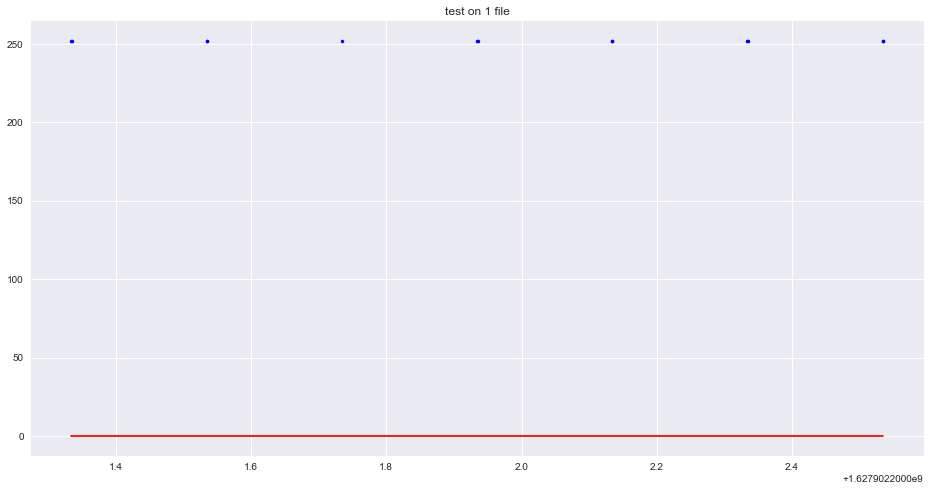

In [127]:
# example on one file
s, g, _ = read_metadata(canfile, gpsfile)
speed_ts, lead_distance_ts, cruise_control_state_ts = read_data(s, g)
event_times = find_crossing(speed_ts, lead_distance_ts, cruise_control_state_ts,
                            with_cruise_control=False,
                            prev_treshold=100,
                            next_treshold=90,
                            speed_treshold=20,
                            verbose=True)
strymread.plt_ts(lead_distance_ts)
plot_events_over_lead('test on 1 file', lead_distance_ts['Message'], lead_distance_ts['Time'], event_times)

# NOTE: obtained results varies deeply depending on the tresholds used

[2021_11_09_18_28_44] (root) INFO: Vehicle model infered is toyota-rav4-2021
[2021_11_09_18_28_45] (cantools.database.can.database) WARNING: Overwriting message 'GAS_PEDAL' with 'GAS_PEDAL' in the name to message dictionary.
reading of /Users/noecarras/Documents/03_Berkeley_EECS/cours/Capstone_RL_validation/capstone_circles_rl_validation/analyses/2021-08-02-01-14-34_2T3W1RFVXMW116290_CAN_Messages.csv was succesful? True
[2021_11_09_18_28_45] (root) INFO: Reading GPS file /Users/noecarras/Documents/03_Berkeley_EECS/cours/Capstone_RL_validation/capstone_circles_rl_validation/analyses/2021-08-02-01-14-34_2T3W1RFVXMW116290_GPS_Messages.csv
GPS signal first acquired at 2021-08-01 16:15:45:000000
reading of /Users/noecarras/Documents/03_Berkeley_EECS/cours/Capstone_RL_validation/capstone_circles_rl_validation/analyses/2021-08-02-01-14-34_2T3W1RFVXMW116290_GPS_Messages.csv was succesful? True
there was an issue trying to scan 2021-08-02-01-14-34_2T3W1RFVXMW116290. 
Failed on: index 0 is out o

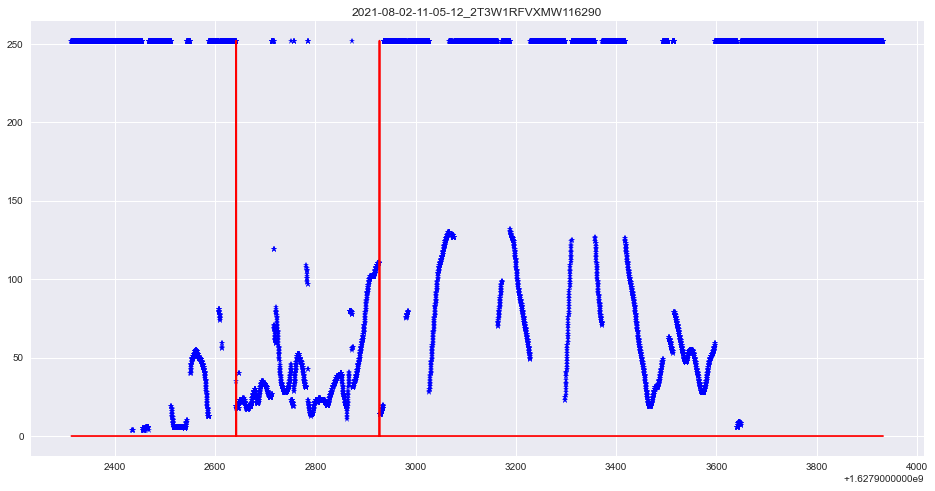

[2021_11_09_18_29_25] (root) INFO: Vehicle model infered is toyota-rav4-2021
[2021_11_09_18_29_25] (cantools.database.can.database) WARNING: Overwriting message 'GAS_PEDAL' with 'GAS_PEDAL' in the name to message dictionary.
reading of /Users/noecarras/Documents/03_Berkeley_EECS/cours/Capstone_RL_validation/capstone_circles_rl_validation/analyses/2021-08-02-12-03-21_2T3W1RFVXMW116290_CAN_Messages.csv was succesful? True
Nothing significant to read in /Users/noecarras/Documents/03_Berkeley_EECS/cours/Capstone_RL_validation/capstone_circles_rl_validation/analyses/2021-08-02-12-03-21_2T3W1RFVXMW116290_GPS_Messages.csv. No further analysis is warranted.
reading of /Users/noecarras/Documents/03_Berkeley_EECS/cours/Capstone_RL_validation/capstone_circles_rl_validation/analyses/2021-08-02-12-03-21_2T3W1RFVXMW116290_GPS_Messages.csv was succesful? False
acceptable range for speed > 20 m/s: []
acceptable range for cruise_control activated: []
number of crossings detected: 0
number of valid cros

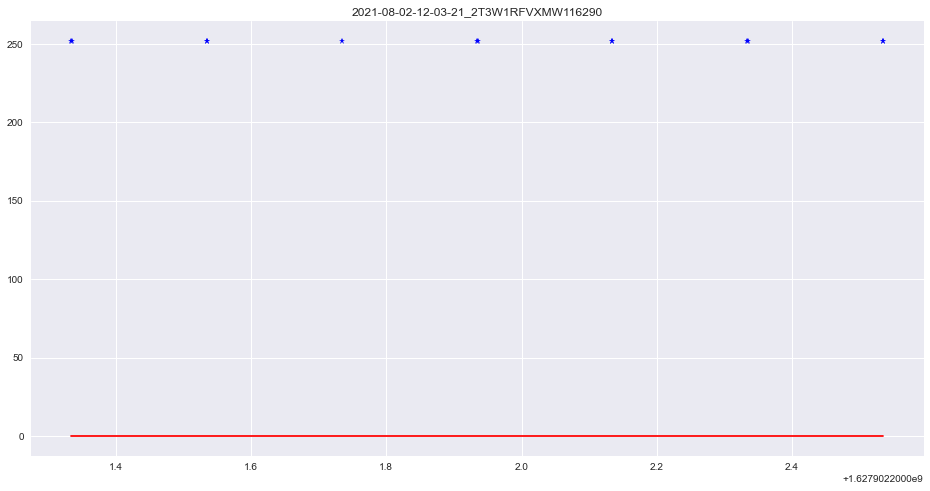

[2021_11_09_18_29_30] (root) INFO: Vehicle model infered is toyota-rav4-2021
[2021_11_09_18_30_01] (cantools.database.can.database) WARNING: Overwriting message 'GAS_PEDAL' with 'GAS_PEDAL' in the name to message dictionary.
reading of /Users/noecarras/Documents/03_Berkeley_EECS/cours/Capstone_RL_validation/capstone_circles_rl_validation/analyses/2021-08-02-14-22-46_2T3W1RFVXMW116290_CAN_Messages.csv was succesful? True
[2021_11_09_18_30_01] (root) INFO: Reading GPS file /Users/noecarras/Documents/03_Berkeley_EECS/cours/Capstone_RL_validation/capstone_circles_rl_validation/analyses/2021-08-02-14-22-46_2T3W1RFVXMW116290_GPS_Messages.csv
GPS signal first acquired at 2021-08-02 06:22:52:280000
reading of /Users/noecarras/Documents/03_Berkeley_EECS/cours/Capstone_RL_validation/capstone_circles_rl_validation/analyses/2021-08-02-14-22-46_2T3W1RFVXMW116290_GPS_Messages.csv was succesful? True
acceptable range for speed > 20 m/s: [{'beg': 1627911186.724326, 'end': 1627911710.009731}, {'beg': 1

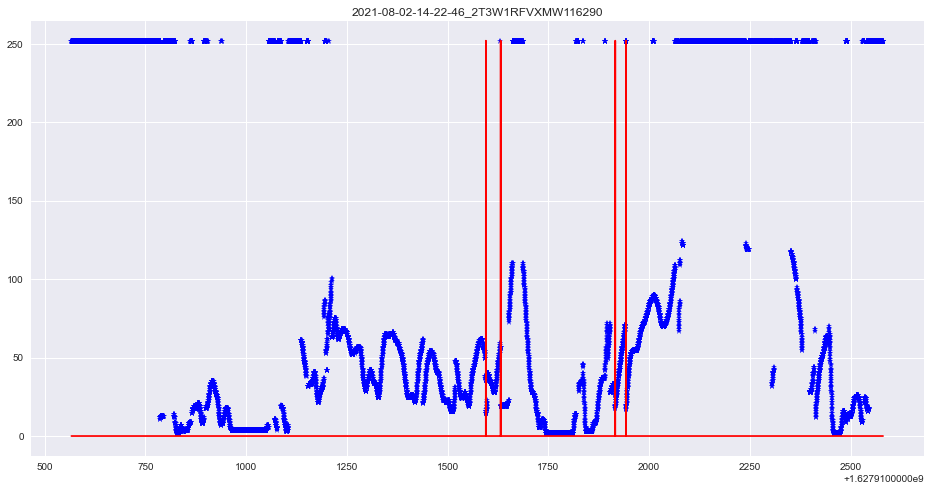

[2021_11_09_18_30_10] (root) INFO: Vehicle model infered is toyota-rav4-2021
[2021_11_09_18_30_10] (cantools.database.can.database) WARNING: Overwriting message 'GAS_PEDAL' with 'GAS_PEDAL' in the name to message dictionary.
reading of /Users/noecarras/Documents/03_Berkeley_EECS/cours/Capstone_RL_validation/capstone_circles_rl_validation/analyses/2021-08-02-14-34-31_2T3W1RFVXMW116290_CAN_Messages.csv was succesful? True
[2021_11_09_18_30_10] (root) INFO: Reading GPS file /Users/noecarras/Documents/03_Berkeley_EECS/cours/Capstone_RL_validation/capstone_circles_rl_validation/analyses/2021-08-02-14-34-31_2T3W1RFVXMW116290_GPS_Messages.csv
GPS signal first acquired at 2021-08-02 06:34:33:100000
reading of /Users/noecarras/Documents/03_Berkeley_EECS/cours/Capstone_RL_validation/capstone_circles_rl_validation/analyses/2021-08-02-14-34-31_2T3W1RFVXMW116290_GPS_Messages.csv was succesful? True
there was an issue trying to scan 2021-08-02-14-34-31_2T3W1RFVXMW116290. 
Failed on: index 0 is out o

In [124]:
def analyse_events_and_plot(name, canfile, gpsfile, with_cruise_control, prev_treshold, next_treshold, speed_treshold, verbose):
    s, g, _ = read_metadata(canfile, gpsfile)
    speed, lead_dist, cc_state = read_data(s, g)
    event_times = find_crossing(speed, lead_dist, cc_state,
                            with_cruise_control=with_cruise_control,
                            prev_treshold=prev_treshold,
                            next_treshold=next_treshold,
                            speed_treshold=speed_treshold,
                            verbose=verbose)
    strymread.plt_ts(lead_distance_ts)
    plot_events_over_lead(name, lead_dist['Message'], lead_dist['Time'], event_times)

for file in file_choser:
    try:
        can, gps = format_files_can_gps(folder, file)
        analyse_events_and_plot(file, can, gps,
                                with_cruise_control=False,
                                prev_treshold=22,
                                next_treshold=20,
                                speed_treshold=20,
                                verbose=True)
    except Exception as err:
        print(f'there was an issue trying to scan {file}. \nFailed on: {err}')


# Questions to ask:
- unit of lead_distance? feet, meters or something else
- same for speed -> seems to be in km/h though (max around 120)
- assumptions for previous_treshold and next_treshold?
- ask for sampling frequencies, things used to resolve those issues by the other members of CIRCLES?
- no SQL DB tools available on CyVerse -> will first be CSV
- metadata and all: what would be useful for sorting on?

# other personal work todo
- checkout strym tutorials: https://jmscslgroup.github.io/strym/
- checkout pandas tutorials: https://pandas.pydata.org/pandas-docs/stable/getting_started/index.html#getting-started
- strymread can only be used inside of jupiter notebooks -> requires special care for launching within a notebook: https://towardsdatascience.com/how-to-run-jupyter-notebook-on-docker-7c9748ed209f

# analysis of the first files
good things:
- finds places with logical crossings
issues:
- double crossing? what does it relates to in real life?
- how to set the tresholds? can give a lot or a few examples. -> What is the distance of the crossings that we want to see and test upon?
- cruise control state? What is the good way of finding it? -> doesn't seem to be on at all...
notes:
- setting the tresholds to crossings where the car in front is at less than 10 units doesn't give any examples
- a lot of files seems 'broken'

# TODO for next week
- File crawler -> be able to download and delete all the acquisitions from all the places where they are located on CyVerse
- CSV write of the DB
- improve on this detection algorithm